In [31]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [45]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Load predictions

## NCV

In [43]:
with open("../output/predictions/outer_cv_accumulated_preds_all_algorithms_all_features.pkl", "rb") as f_r:
    all_features = pickle.load(f_r)

with open("../output/predictions/outer_cv_accumulated_preds_all_algorithms_only_clinical.pkl", "rb") as f_r:
    clinical = pickle.load(f_r)
    
with open("../output/predictions/outer_cv_accumulated_preds_all_algorithms_only_calcification.pkl", "rb") as f_r:
    calcification = pickle.load(f_r)    

## External validation

In [33]:
all_features_external = pd.read_csv("../output/predictions/test_preds_tuned_LGBM_all_features_0035_70trials.csv")
clinical_external = pd.read_csv("../output/predictions/test_preds_tuned_LGBM_only_clinical_0035_70trials.csv")
calcification_external = pd.read_csv("../output/predictions/test_preds_tuned_LGBM_only_calcification_0035_70trials.csv")

# Utilities

In [34]:
def plot_roc_pair(cv_preds, title, ax):
    #cmap = plt.cm.get_cmap("Set1")
    #colors = cmap(np.arange(6))
    colors = [blue, darksalmon, "red"]

    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        fprs = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        gts = outer_cv_data['gt']
        probas = outer_cv_data['probas']

        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            auc_val = roc_auc_score(split_gts, split_probas[:, 1])
            aucs.append(auc_val)

            # compute ROC curve components
            fpr, tpr, _ = roc_curve(split_gts, split_probas[:, 1])
            tprs.append(np.interp(fprs, fpr, tpr))

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std_tprs = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        fpr, tpr, thresholds = roc_curve(outer_cv_data['gt_conc'], outer_cv_data['probas_conc'][:, 1])

        auc_low, auc_med, auc_up = np.percentile(aucs, [2.5, 50, 97.5])
        lab = "{} ({:.3f} [{:.2f} - {:.2f}])".format(algo_name, auc_med, auc_low, auc_up)

        ax.plot(fpr,
                tpr,
                label=lab,
                lw=1.1,
                linestyle='-',
                alpha=1.0,
                color=colors[j])
        #ax.fill_between(fprs, tprs_lower, tprs_upper,
        #                color=colors[j],
        #                alpha=0.08)

    ax.set_xlabel('1 - Specificity',
                  fontdict={"weight": "normal", "size": 16},
                  labelpad=10)
    ax.set_ylabel('Sensitivity',
                  fontdict={"weight": "normal", "size": 16},
                  labelpad=10)
    #plt.title(title, fontsize=12, pad=20)
    ax.set_title(title, fontsize=15, pad=10)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    #ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label="Baseline", alpha=.8)
    ax.legend(loc='lower right', fontsize='medium')
    
    # compare aucs w/ delong test and visualize P value
    keys = list(cv_preds.keys())
    ground_truths = cv_preds[keys[0]]['gt_conc']
    probas_all = cv_preds[keys[0]]["probas_conc"]
    probas_plaque = cv_preds[keys[1]]["probas_conc"]
    probas_clinical = cv_preds[keys[2]]["probas_conc"]
    P1 = delong_roc_test(ground_truths, probas_all[:, 1], probas_clinical[:, 1])
    P1 = 10**P1.item()
    P2 = delong_roc_test(ground_truths, probas_all[:, 1], probas_plaque[:, 1])
    P2 = 10**P2.item()    
    
    P1_no_leading_zero = f"{P1:.3f}".lstrip("0")
    P1_to_viz = "All vs clinical only: P < .001" if P1 < 0.001 else f"All vs clinical only: P = {P1_no_leading_zero}"
    ax.text(0.03, 0.95, P1_to_viz, 
            transform=ax.transAxes, 
            size=10, weight="normal")
    
    P2_no_leading_zero = f"{P2:.3f}".lstrip("0")
    P2_to_viz = "All vs plaque only: P < .001" if P2 < 0.001 else f"All vs plaque only: P = {P2_no_leading_zero}"
    ax.text(0.03, 0.9, P2_to_viz, 
            transform=ax.transAxes, 
            size=10, weight="normal")    

    return ax

In [35]:
def plot_average_roc_curves(cv_preds,
                            ax,
                            highlight_best: bool = True):
    """
    Plot average cross-validation ROC curves corresponding to the best models
    found during the inner cross-validation procedure of the nested cv.

    Parameters
    ----------
    cv_preds: Dict[str, Dict[str, list]]
    conf: CfgNode
    ax: plt.Axes
    highlight_best: bool (default = True)

    Returns
    -------
    Tuple[plt.Figure, plt.Axes]
        A tuple of figure and axes.
    """
    cmap = plt.cm.get_cmap("Set1")
    colors = cmap(np.arange(6))

    # f, ax = plt.subplots(1, 1, figsize=(10, 10))

    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        fprs = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        gts = outer_cv_data['gt']
        probas = outer_cv_data['probas']

        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            auc_val = roc_auc_score(split_gts, split_probas[:, 1])
            aucs.append(auc_val)

            # compute ROC curve components
            fpr, tpr, _ = roc_curve(split_gts, split_probas[:, 1])
            tprs.append(np.interp(fprs, fpr, tpr))

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std_tprs = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        fpr, tpr, thresholds = roc_curve(outer_cv_data['gt_conc'], outer_cv_data['probas_conc'][:, 1])

        auc_low, auc_med, auc_up = np.percentile(aucs, [2.5, 50, 97.5])
        lab = "{} ({:.3f} [{:.2f} - {:.2f}])".format(ALGO_NAMES_MAP[algo_name], auc_med, auc_low, auc_up)

        ax.plot(fpr,
                tpr,
                label="Best algorithm" if algo_name == ALGORITHM_TO_TUNE else None,
                lw=5.0 if algo_name == ALGORITHM_TO_TUNE and highlight_best else 4,
                linestyle=(0, (3, 1, 1, 1)) if algo_name == ALGORITHM_TO_TUNE and highlight_best else '-',
                alpha=1.0,
                color=colors[j])
        #ax.fill_between(fprs, tprs_lower, tprs_upper,
        #                color=colors[j],
        #                alpha=0.08)

    ax.set_xlabel('1 - Specificity',
                  fontdict={"weight": "bold", "size": 30},
                  labelpad=20)
    ax.set_ylabel('Sensitivity',
                  fontdict={"weight": "bold", "size": 30},
                  labelpad=20)
    # plt.title("Algorithm comparison", fontsize=20, pad=20)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray',
            #label="Baseline", 
            alpha=.8)
    ax.legend(loc='lower right', fontsize='large', prop={"size": 28})

    return ax

# Miscellaneous

In [36]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFD1C2"
darksalmon = "#e57e5e"

custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [lightblue, salmon], N=256)

# NCV data

## Compare each algorithm with itself
In this case we are comparing ROC AUCs of each model fitted using
a) all features and b) without plaque information

In [49]:
for algo_name in all_features.keys():
    outer_cv_all_features = all_features[algo_name]
    outer_cv_clinical = clinical[algo_name]
    outer_cv_calcification = calcification[algo_name]    
    
    ground_truths = outer_cv_all_features["gt_conc"]
    proba_all_features = outer_cv_all_features["probas_conc"]
    proba_clinical = outer_cv_clinical["probas_conc"]
    proba_calcification = outer_cv_calcification["probas_conc"]
    
    auc_all = roc_auc_score(ground_truths, proba_all_features[:, 1])
    auc_clinical = roc_auc_score(ground_truths, proba_clinical[:, 1])
    auc_calcification = roc_auc_score(ground_truths, proba_calcification[:, 1])
    
    P1 = delong_roc_test(ground_truths, proba_all_features[:, 1], proba_clinical[:, 1])
    P2 = delong_roc_test(ground_truths, proba_all_features[:, 1], proba_calcification[:, 1]) # mi aspetto non rilevanza
    
    print(f"{algo_name}")
    print("plaque+clinical vs clinical only (adding calcification data)\n")
    print("P value : {}".format(10**P1.item()))
    print("AUCs : {} vs {}".format(auc_clinical, auc_all))
    
    print("-"*50)
    print("plaque+clinical vs calcification only (adding clinical data)\n")
    print("P value : {}".format(10**P2.item()))
    print("AUCs : {} vs {}".format(auc_calcification, auc_all))
    print("\n")

LGBM
plaque+clinical vs clinical only (adding calcification data)

P value : 7.696488770289991e-89
AUCs : 0.5676748966884458 vs 0.6961296909029989
--------------------------------------------------
plaque+clinical vs calcification only (adding clinical data)

P value : 1.1501821978387213e-25
AUCs : 0.6449108937845536 vs 0.6961296909029989


MLP
plaque+clinical vs clinical only (adding calcification data)

P value : 8.475519365744552e-56
AUCs : 0.5264651044284359 vs 0.6520204040319428
--------------------------------------------------
plaque+clinical vs calcification only (adding clinical data)

P value : 0.024501640047703964
AUCs : 0.6391721812698945 vs 0.6520204040319428


SVC
plaque+clinical vs clinical only (adding calcification data)

P value : 0.15544592462845705
AUCs : 0.4964944574747306 vs 0.5099164781928855
--------------------------------------------------
plaque+clinical vs calcification only (adding clinical data)

P value : 5.875889209908453e-07
AUCs : 0.5567643240073714 vs

/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_50258/124398649.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_50258/124398649.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var/fol

In [8]:
# make a plot for each algorithm showing average ROC curves using
# all features and without using plaque informations. AUCs in the legend
# and P value on che chart maybe ?

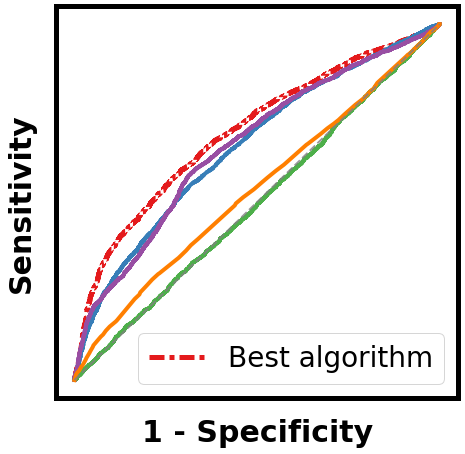

In [230]:
ALGORITHM_TO_TUNE = "LGBM"

f, ax = plt.subplots(figsize=(7.2, 7.2))
plot_average_roc_curves(all_features, ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(5)  # change width
    ax.spines[axis].set_color('black')    # change color
    
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.savefig("../output/plots/TIFF/ROC_curves.tiff", format="tiff", dpi=f.dpi, bbox_inches='tight')


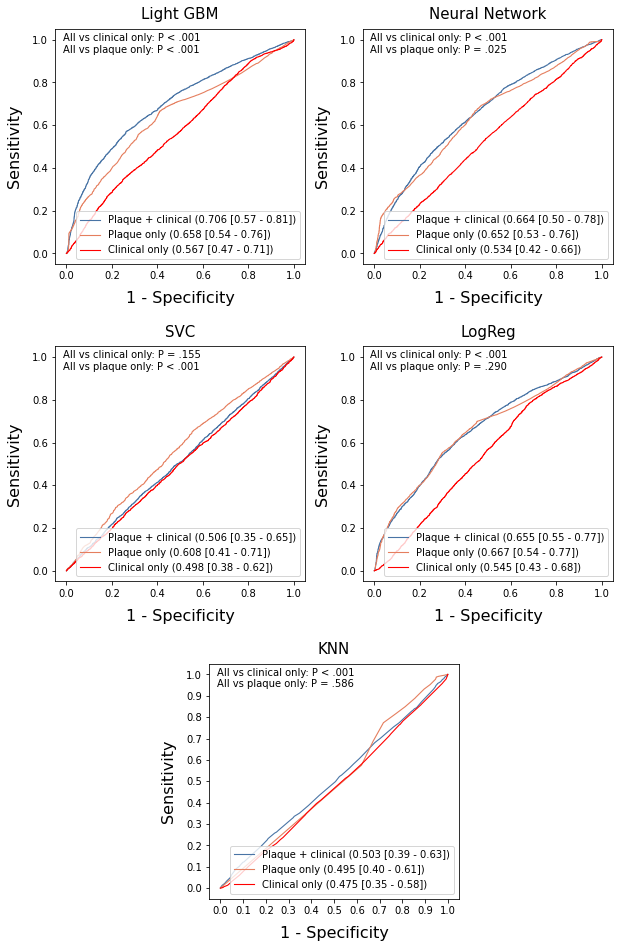

In [44]:
import matplotlib.gridspec as gridspec
import warnings
from sklearn.metrics import roc_auc_score, roc_curve

ALGO_SHORT_NAMES = ["MLP", "LGBM", "SVC", "LR", "KNN"]
ALGO_LONG_NAMES = ["Neural Network", "Light GBM", "SVC", "LogReg", "KNN"]
ALGO_NAMES_MAP = dict(zip(ALGO_SHORT_NAMES, ALGO_LONG_NAMES))

f, ax = plt.subplots(figsize=(10, 16))
gs = gridspec.GridSpec(3, 4, hspace=0.35, wspace=0.6)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,0:2])
ax4 = plt.subplot(gs[1,2:])
ax5 = plt.subplot(gs[2,1:3])
#ax6 = plt.subplot(gs[2,2:])
#ax7 = plt.subplot(gs[3,1:3])
fig = plt.gcf()
#gs.tight_layout(fig)
axes = [ax1,ax2,ax3,ax4,ax5]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for ax, (algo_name, outer_cv_data) in zip(axes, all_features.items()):
        probas = {"Plaque + clinical": all_features[algo_name],
                  "Plaque only": calcification[algo_name],
                 "Clinical only": clinical[algo_name]}
        algo_name = ALGO_NAMES_MAP[algo_name]
        plot_roc_pair(probas, algo_name, ax)

#plt.savefig("../output/plots/ROC_AUC_comparison.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/TIFF/ROC_AUC_comparison.tiff", format="tiff", pil_kwargs={"compression": "tiff_lzw"},
            dpi=1200, bbox_inches='tight')
plt.show()

# Compare Light GBM with all other algorithms on outer CV

In [31]:
probas_lgbm = all_features["LGBM"]["probas_conc"]
ground_truths = all_features["LGBM"]["gt_conc"]

for algo_name in all_features.keys():
    if algo_name != "LGBM":
        probas_curr_algo = all_features[algo_name]["probas_conc"]

        P = delong_roc_test(ground_truths, 
                            probas_lgbm[:, 1], 
                            probas_curr_algo[:, 1])
        print("LGBM vs {} - P value: {}".format(algo_name, 10**P.item()))

LGBM vs MLP - P value: 1.093115856075474e-18
LGBM vs SVC - P value: 1.5721517661264962e-95
LGBM vs LR - P value: 2.910685939037191e-21
LGBM vs KNN - P value: 1.1440136359415936e-140


/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_40510/124398649.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_40510/124398649.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var/fol

# External validation data

In [37]:
from mlxtend.evaluate import mcnemar_table, mcnemar

In [38]:
tb = mcnemar_table(y_target=all_features_external["target"], 
                   y_model1=np.where(all_features_external["proba"] > 0.4853442, 1, 0),
                   y_model2=np.where(clinical_external["proba"] > 0.5055034, 1, 0))

In [41]:
tb

array([[88, 24],
       [14, 33]])

In [39]:
chi2, p = mcnemar(ary=tb, corrected=True)

In [40]:
p

0.14429205544010104

In [52]:
algo_name = "LGBM"

auc_all_external = roc_auc_score(all_features_external["target"], all_features_external["proba"])
auc_clinical_external = roc_auc_score(all_features_external["target"], clinical_external["proba"])
auc_calcification_external = roc_auc_score(all_features_external["target"], calcification_external["proba"])

P1_external = delong_roc_test(all_features_external["target"], 
                     all_features_external["proba"], 
                     clinical_external["proba"])

P2_external = delong_roc_test(all_features_external["target"], 
                     all_features_external["proba"], 
                     calcification_external["proba"])

P3_external = delong_roc_test(all_features_external["target"], 
                     clinical_external["proba"], 
                     calcification_external["proba"])

print(f"{algo_name}")
print("plaque+clinical vs clinical only (adding calcification data)\n")
print("P value : {}".format(10**P1_external.item()))
print("AUCs : {} vs {}".format(auc_clinical_external, auc_all_external))

print("-"*50)

print(f"{algo_name}")
print("plaque+clinical vs calcification only (adding clinical data)\n")
print("P value : {}".format(10**P2_external.item()))
print("AUCs : {} vs {}".format(auc_calcification_external, auc_all_external))

print("-"*50)

print(f"{algo_name}")
print("clinical only vs calcification only\n")
print("P value : {}".format(10**P3_external.item()))
print("AUCs : {} vs {}".format(auc_clinical_external, auc_calcification_external))

LGBM
plaque+clinical vs clinical only (adding calcification data)

P value : 0.08056802572785537
AUCs : 0.618390422347855 vs 0.6909710675091454
--------------------------------------------------
LGBM
plaque+clinical vs calcification only (adding clinical data)

P value : 0.011384829922523442
AUCs : 0.7578150981044232 vs 0.6909710675091454
--------------------------------------------------
LGBM
clinical only vs calcification only

P value : 0.008551644267832923
AUCs : 0.618390422347855 vs 0.7578150981044232


/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_50258/124398649.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/var/folders/1p/1ck1ggqs5jg_wdfpm41gx6dr0000gn/T/ipykernel_50258/124398649.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/var/fol